## **Solving differential equations using neural networks**

**Our first problem is to solve:**

\begin{equation*}
    \bold{y' = y \quad y(0) = 1}
\end{equation*}

In [1]:
# Importing libraries
import deepxde as dde
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Setting up the ODE problem: y' - y = 0
differential_equation = lambda x, y: dde.grad.jacobian(y, x, i = 0, j = 0) - y

# Exact solution
f = lambda x: np.exp(x)

### **DeepXDE `jacobian` Function Documentation**  

---

#### **Purpose**  
Computes the **Jacobian matrix** $J$ of outputs y with respect to inputs x, where:

\begin{equation*}
   J[i, j] = \frac{\partial y_i}{\partial x_j}
\end{equation*}  

Designed for efficient first-order derivative calculations in physics-informed neural networks (PINNs).

#### **Parameters**  

| Parameter | Type | Description |  
|-----------|------|-------------|  
| `ys` | `Tensor` | Output tensor of shape `(batch_size, dim_y)` or `(batch_size_out, batch_size, dim_y)`. |  
| `xs` | `Tensor` | Input tensor of shape `(batch_size, dim_x)`. |  
| `i` | `int` or `None` | Row index. If `None`, returns the `j`-th column. |  
| `j` | `int` or `None` | Column index. If `None`, returns the `i`-th row. |  

**Constraints**:  
- `i` and `j` cannot both be `None` (unless the Jacobian is a single value).  

#### **Returns**  
| Return Type | Shape | Description |  
|-------------|-------|-------------|  
| `J[i, j]` | `(batch_size, 1)` or `(batch_size_out, batch_size, 1)` | Single entry of the Jacobian. |  
| `J[i, :]` | `(batch_size, dim_x)` or `(batch_size_out, batch_size, dim_x)` | Full row (gradient of \( y_i \)). |  
| `J[:, j]` | `(batch_size, dim_y)` or `(batch_size_out, batch_size, dim_y)` | Full column. |   

#### **Example Scenarios**  
1. **Single Entry**:  
   ```python  
   # Compute ∂y_0/∂x_1  
   dy0_dx1 = dde.grad.jacobian(y, x, i=0, j=1)  
   ```  

2. **Full Gradient of One Output**:  
   ```python  
   # Compute ∇y_0 (all partial derivatives of y_0)  
   grad_y0 = dde.grad.jacobian(y, x, i=0, j=None)  
   ```  

3. **Full Column (All Outputs w.r.t. One Input)**:  
   ```python  
   # Compute ∂y/∂x_0  
   dy_dx0 = dde.grad.jacobian(y, x, i=None, j=0)  
   ```  
---

In [3]:
# Creating the interval domain
domain = dde.geometry.Interval(0, 3)

In [4]:
# Defining the Dirichlet boundaries
initial_condition = dde.icbc.DirichletBC(
                                        geom = domain,
                                        func = lambda _: 1, 
                                        on_boundary = lambda x, _: np.isclose(x[0], 0),
                                        component = 0
                                        )

### **Boundary Conditions Overview**  
Boundary conditions (BCs) constrain the solution of differential equations at domain boundaries. DeepXDE provides flexible BC implementations for PINNs.

### **Base Class: `BC`**  
*Abstract base class for all boundary conditions.*  

#### **Key Parameters**  
| Parameter | Type | Description |  
|-----------|------|-------------|  
| `geom` | `Geometry` | Domain geometry (e.g., `Interval`, `Rectangle`). |  
| `on_boundary` | `Callable` | Function `(x, on_boundary) -> bool` to identify boundary points. |  
| `component` | `int` | Output component index to which the BC applies (default: `0`). |  

#### **Key Methods**  
| Method | Purpose |  
|--------|---------|  
| `collocation_points(X)` | Selects boundary points from input `X`. |  
| `error(X, inputs, outputs, ...)` | Computes the BC loss (must be implemented by subclasses). |  
| `filter(X)` | Filters boundary points from collocation data. |  

### **Concrete Implementation of the DirichletBC**  

#### **`DirichletBC`**  
*Enforces fixed values on boundaries (e.g., $y(\text{boundary}) = f(x)$).*  

##### **Parameters**  
| Parameter | Description |  
|-----------|-------------|  
| `func` | `Callable` prescribing the boundary values. Takes input coordinates `x` and returns the target value. |  

##### **Example**  
```python  
# Enforce y = sin(x) at x = 0  
bc = dde.icbc.DirichletBC(  
    geom=geometry,  
    func=lambda x: np.sin(x[:, 0:1]),  # y = sin(x) at boundary  
    on_boundary=lambda x, _: np.isclose(x[0], 0),  # Points where x=0  
    component=0  # Applies to the first output  
)  
```

---

In [5]:
# Configuring training data
data = dde.data.PDE(
                    geometry = domain,
                    pde = differential_equation,
                    bcs = [initial_condition],
                    train_distribution = "Hammersley",
                    num_domain = 200,
                    num_boundary = 2,
                    num_test = 200,
                    solution = f
                    )

### **DeepXDE PDE Class Documentation**  
*Physics-Informed Neural Network (PINN) Configuration for Solving ODEs/PDEs*

### **1. Core Functionality**  
The `PDE` class configures neural networks to solve:  
- **Ordinary Differential Equations (ODEs)**  
- **Time-Independent Partial Differential Equations (PDEs)**  

### **2. Key Parameters**  

### **Problem Definition**  
| Parameter | Type | Description |  
|-----------|------|-------------|  
| `geometry` | `Geometry` | Domain specification (e.g., `Interval`, `Rectangle`, `TimeDomain`). |  
| `pde` | `Callable` or `List[Callable]` | PDE residual function(s). Returns `0` when satisfied. |  
| `bcs` | `List[BC]` | Boundary/initial conditions (empty list `[]` if none). |  

### **Training Configuration**  
| Parameter | Default | Description |  
|-----------|---------|-------------|  
| `num_domain` | `0` | Collocation points inside the domain. |  
| `num_boundary` | `0` | Points on boundaries (for BC enforcement). |  
| `train_distribution` | `"Hammersley"` | Sampling method: `"uniform"`, `"pseudo"`, `"LHS"`, `"Halton"`, `"Sobol"`. |  

### **Validation & Advanced**  
| Parameter | Description |  
|-----------|-------------|  
| `solution` | Analytical solution (optional, for error computation). |  
| `num_test` | Test points for validation (defaults to training data if `None`). |  
| `auxiliary_var_function` | Adds external variables (e.g., parameters) to inputs. |  

### **3. Key Attributes**  

### **Training Data**  
| Attribute | Description |  
|-----------|-------------|  
| `train_x_all` | Collocation points (unordered, no duplicates). |  
| `train_x_bc` | Boundary condition points. |  
| `train_x` | Combined training data (BCs first, then PDE points). |  

### **Testing Data**  
| Attribute | Description |  
|-----------|-------------|  
| `test_x` | Test points (same BC points as training). |  

### **4. Methods**  

### **Data Management**  
| Method | Purpose |  
|--------|---------|  
| `add_anchors()` | Add fixed training points. |  
| `resample_train_points()` | Re-generate training points. |  

### **Training/Testing**  
| Method | Purpose |  
|--------|---------|  
| `train_next_batch()` | Fetch training data. |  
| `test()` | Generate test dataset. |    

---

In [6]:
# Creating the neural network
neural_network = dde.nn.FNN(
                            layer_sizes = [1] + [50] * 3 + [1],  # 1 input → 3 hidden layers (50 neurons each) → 1 output
                            activation = "tanh",
                            kernel_initializer = "Glorot normal"
                            )

neural_network.apply_output_transform(lambda x, y: y * x + 1) # Ensure y(0) = 1

In [7]:
# Creating the model
model = dde.Model(data = data,
                  net = neural_network)

In [8]:
# Training phase 1: Adam optimizer
model.compile(
              optimizer = "adam",
              lr = 1e-03,
              metrics = ["l2 relative error"]
              )

model.train(iterations = 15_000)

Compiling model...
'compile' took 2.945834 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.71e+00, 0.00e+00]    [1.71e+00, 0.00e+00]    [7.06e-01]    
1000      [1.54e-04, 0.00e+00]    [1.42e-04, 0.00e+00]    [6.79e-04]    
2000      [4.55e-04, 0.00e+00]    [4.66e-04, 0.00e+00]    [6.03e-03]    
3000      [5.54e-05, 0.00e+00]    [4.89e-05, 0.00e+00]    [1.25e-04]    
4000      [3.60e-05, 0.00e+00]    [3.10e-05, 0.00e+00]    [1.10e-04]    
5000      [2.48e-05, 0.00e+00]    [2.17e-05, 0.00e+00]    [5.88e-04]    
6000      [1.81e-05, 0.00e+00]    [1.60e-05, 0.00e+00]    [5.57e-04]    
7000      [9.32e-06, 0.00e+00]    [7.31e-06, 0.00e+00]    [5.66e-05]    
8000      [1.11e-05, 0.00e+00]    [1.02e-05, 0.00e+00]    [5.99e-04]    
9000      [4.96e-06, 0.00e+00]    [3.59e-06, 0.00e+00]    [1.42e-04]    
10000     [4.07e-06, 0.00e+00]    [3.01e-06, 0.00e+00]    [1.03e-04]    
11000     [4.51e-05, 0.00e+00]    [4.50e-05, 0.00e+00]    [

(<deepxde.model.LossHistory at 0x1f649fc27b0>,
 <deepxde.model.TrainState at 0x1f649fc2a50>)

In [9]:
# Training phase 2: L-BFGS fine-tuning
model.compile(
              optimizer = "L-BFGS",
              metrics = ["l2 relative error"]
              )

model.train()

Compiling model...
'compile' took 0.001145 s

Training model...

Step      Train loss              Test loss               Test metric   
15000     [3.33e-06, 0.00e+00]    [2.65e-06, 0.00e+00]    [2.60e-05]    
15002     [3.33e-06, 0.00e+00]    [2.65e-06, 0.00e+00]    [2.55e-05]    

Best model at step 14000:
  train loss: 3.26e-06
  test loss: 2.68e-06
  test metric: [9.82e-05]

'train' took 0.210092 s



(<deepxde.model.LossHistory at 0x1f649fc27b0>,
 <deepxde.model.TrainState at 0x1f649fc2a50>)

### **DeepXDE Model Class Documentation**  
*Core training interface for physics-informed neural networks (PINNs)*

### **1. Overview**  
The `Model` class connects a neural network (`net`) with problem data (`data`) to train PINNs for solving differential equations.

### **2. Initialization**  
```python
model = dde.Model(data, net)
```

| Parameter | Type | Description |
|-----------|------|-------------|
| `data` | `dde.data.Data` | Problem definition (PDE/ODE + BCs) |
| `net` | `dde.nn.NN` | Neural network architecture |

### **3. Key Methods**  

### **3.1 `compile()` - Configure Training**  

| Parameter | Options/Type | Description |
|-----------|--------------|-------------|
| `optimizer` | `"adam"`, `"L-BFGS"`, or backend optimizer | Training algorithm |
| `lr` | float | Learning rate (ignored for L-BFGS) |
| `loss` | `"MSE"` (default), custom function | Loss function |
| `metrics` | List e.g., `["l2 error"]` | Validation metrics |

### **3.2 `train()` - Run Training**  

| Parameter | Description |
|-----------|-------------|
| `iterations` | Total training steps |
| `display_every` | Print progress every N steps |
| `callbacks` | List of utilities like `PDEPointResampler` |

### **3.3 `predict()` - Generate Solutions**  

### **4. Model Management**  

| Method | Purpose |
|--------|---------|
| `save("path")` | Save model weights |
| `restore("path")` | Load saved model |
| `state_dict()` | Export model parameters |
| `print_model()` | Display trainable variables |

### **Optimizer Selection**  
| Scenario | Optimizer | Notes |
|----------|-----------|-------|
| Initial training | Adam (`lr=1e-3`) | Robust to poor initializations |
| Fine-tuning | L-BFGS | Higher precision |

---

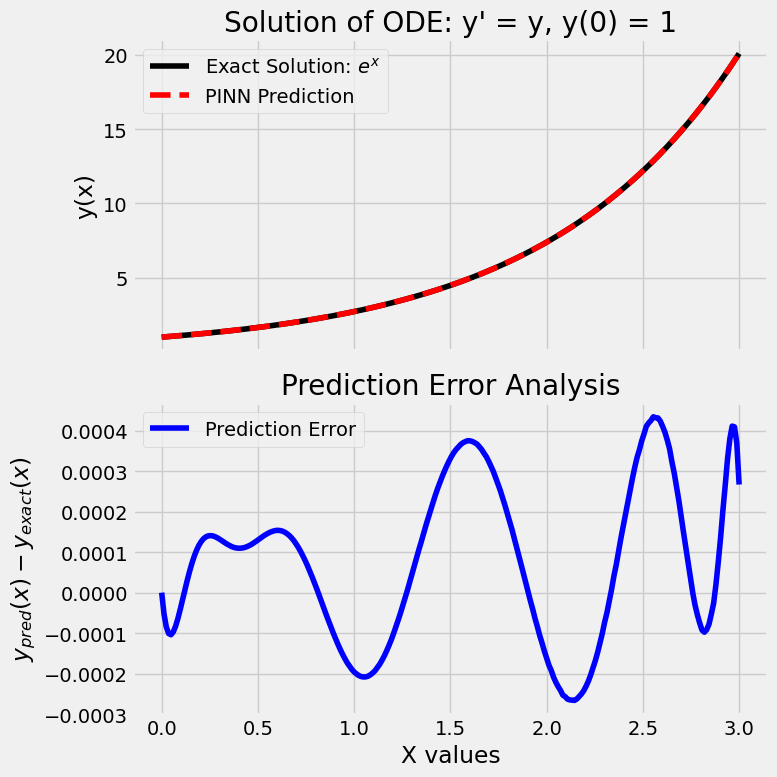

In [10]:
# Predictions
x = np.linspace(0, 3, 250).reshape(-1, 1)
y_pred = model.predict(x)

# Analytical solution
y_exact = f(x)

# Plotting results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8), sharex = True)

ax1.plot(x, y_exact, "k-", label = "Exact Solution: $e^x$")
ax1.plot(x, y_pred, "r--", label = "PINN Prediction")
ax1.set_ylabel("y(x)")
ax1.set_title("Solution of ODE: y' = y, y(0) = 1")
ax1.legend()
ax1.grid(True)

error = y_pred - y_exact
ax2.plot(x, error, "b-", label = "Prediction Error")
ax2.set_xlabel("X values")
ax2.set_ylabel("$y_{pred}(x) - y_{exact}(x)$")
ax2.set_title("Prediction Error Analysis")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Calculating stats
error = np.mean(np.abs(y_pred - y_exact))
std = np.std(np.abs(y_pred - y_exact))
print(f"Error: {error:.4f} +- {std:.4f}")

Error: 0.0002 +- 0.0001


**Let's see now a second order differential equation that depends on time:**

\begin{equation*}
    \bold{y'' - 10 y' + 9y = 5t}
\end{equation*}

**With the following initial conditions:**

\begin{cases}
    y(0) = -1 \\
    y'(0) = 2
\end{cases}

In [12]:
# Defining the time domain
domain = dde.geometry.TimeDomain(0, 0.3)

In [13]:
# Definig the ODE
def differential_equation(t, y):
    
    # First derivative: dy/dt
    dy_dt = dde.grad.jacobian(y, t, i = 0, j = 0)
    
    # Second derivative: d²y/dt²
    d2y_dt2 = dde.grad.hessian(y, t, i = 0, j = 0)
    
    # Returning the ODE residual
    return d2y_dt2 - 10 * dy_dt + 9 * y - 5 * t

### **DeepXDE `hessian` Function Documentation**  

### **Purpose**  
The `hessian` function computes **second-order partial derivatives** of a neural network's output with respect to its inputs, forming the **Hessian matrix** $H$, where:  
\begin{equation*}
    H[i, j] = \frac{\partial^2 y}{\partial x_i \partial x_j}
\end{equation*}
  
This is essential for solving **PDEs involving second-order derivatives** (e.g., Poisson equations, wave equations).

### **Parameters**  

| Parameter | Type | Description |  
|-----------|------|-------------|  
| `ys` | `Tensor` | Output tensor of shape `(batch_size, dim_y)` or `(batch_size_out, batch_size, dim_y)`. |  
| `xs` | `Tensor` | Input tensor of shape `(batch_size, dim_x)`. |  
| `component` | `int` | Selects `ys[:, component]` for differentiation (default: `0`). |  
| `i`, `j` | `int` | Indices specifying which partial derivative to compute (e.g., $\frac{\partial^2 y}{\partial x_0^2}$ for `i=0, j=0`). |  

### **Returns**  
| Output Shape | Description |  
|--------------|-------------|  
| `(batch_size, 1)` | For single-batch inputs. |  
| `(batch_size_out, batch_size, 1)` | For batched inputs. |  

### **Usage Examples**  

### **1. Basic Usage (1D Input)**  
Compute $\frac{d^2 y}{dx^2}$ for a scalar function $y(x)$:  
```python  
d2y_dx2 = dde.grad.hessian(y, x, i=0, j=0)  
```  

### **2. Multi-Dimensional Input**  
For $y(x_0, x_1)$, compute mixed partial derivative $\frac{\partial^2 y}{\partial x_0 \partial x_1}$:  
```python  
d2y_dx0dx1 = dde.grad.hessian(y, x, i=0, j=1)  
```  

### **3. Batched Outputs**  
For multiple outputs $[y_0, y_1]$, compute $\frac{\partial^2 y_1}{\partial x_0^2}$:  
```python  
d2y1_dx02 = dde.grad.hessian(y, x, component=1, i=0, j=0)  
```  
---

In [14]:
# Defining initial conditions
# First IC: y(0) = -1
ic_y = dde.icbc.IC(
                    geom = domain, 
                    func = lambda _: -1, 
                    on_initial = lambda _, on_initial: on_initial, 
                    component = 0
                    )

# Second IC: y'(0) = 2 (requires special handling)
def derivative_error(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i = 0, j = None) - 2

def is_left_boundary(t, on_boundary):
    return on_boundary and np.isclose(t[0], 0)

ic_dy = dde.icbc.OperatorBC(
                            geom = domain,
                            func = derivative_error,
                            on_boundary = is_left_boundary
                            )

In [15]:
# Configuring the ODE
data = dde.data.TimePDE(
                        geometryxtime = domain,
                        pde = differential_equation,
                        ic_bcs = [ic_y, ic_dy],
                        train_distribution = 'Hammersley',
                        num_domain = 200,  
                        num_boundary = 2,    
                        num_test = 200   
                        )

In [16]:
# Building the neural network
network = dde.nn.FNN(
                    [1] + [50] * 3 + [1], # 1 input, 3 hidden layers (50 units), 1 output
                    activation = "tanh",
                    kernel_initializer = "Glorot uniform"
                    )

In [17]:
# Creating the model, compiling and training it twice
model = dde.Model(data = data,
                  net = network)

model.compile(
              optimizer = "adam",
              lr = 1e-03,
              verbose = 1
              )

model.train(iterations = 15_000)

model.compile(optimizer = "L-BFGS")
model.train()

Compiling model...
'compile' took 0.000994 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.30e-01, 1.00e+00, 4.04e+00]    [6.36e-01, 1.00e+00, 4.04e+00]    []  
1000      [4.05e-02, 2.29e+00, 2.31e+00]    [3.95e-02, 2.29e+00, 2.31e+00]    []  
2000      [4.45e-02, 2.28e+00, 2.31e+00]    [4.20e-02, 2.28e+00, 2.31e+00]    []  
3000      [4.54e-02, 2.28e+00, 2.31e+00]    [4.28e-02, 2.28e+00, 2.31e+00]    []  
4000      [4.60e-02, 2.28e+00, 2.31e+00]    [4.34e-02, 2.28e+00, 2.31e+00]    []  
5000      [4.68e-02, 2.28e+00, 2.31e+00]    [4.40e-02, 2.28e+00, 2.31e+00]    []  
6000      [4.71e-02, 2.27e+00, 2.31e+00]    [4.46e-02, 2.27e+00, 2.31e+00]    []  
7000      [8.06e-02, 2.19e+00, 2.29e+00]    [7.52e-02, 2.19e+00, 2.29e+00]    []  
8000      [8.83e-02, 1.88e+00, 2.04e+00]    [8.14e-02, 1.88e+00, 2.04e+00]    []  
9000      [9.52e-02, 1.12e-01, 1.51e-01]    [7.23e-02, 1.12e-01, 1.51e-01]    []  
10000     [3.94

(<deepxde.model.LossHistory at 0x1f65021ed50>,
 <deepxde.model.TrainState at 0x1f65021e990>)

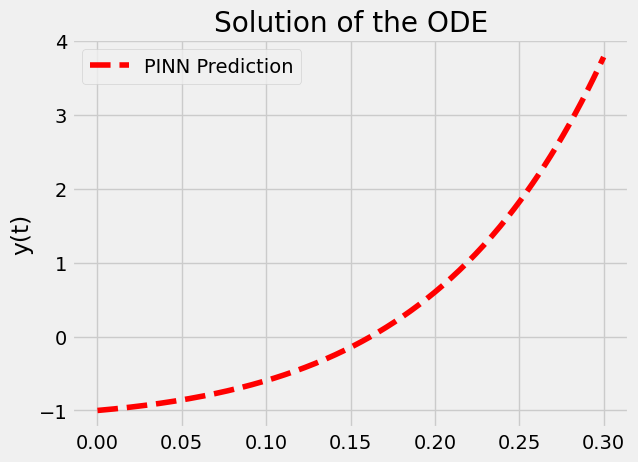

In [18]:
# Making Predictions
t = np.linspace(0, 0.3, 250).reshape(-1, 1)
y_pred = model.predict(t)

# Plotting results
plt.plot(t, y_pred, "r--", label = "PINN Prediction")
plt.ylabel("y(t)")
plt.title("Solution of the ODE")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Computing the exact solution
import sympy as smp

t = smp.symbols("t", real = True, nonnegative = True)
y = smp.Function("y", real = True)(t)

eq = smp.Eq(smp.diff(y, t, 2) - 10 * smp.diff(y, t, 1) + 9 * y, 5 * t)
ics = {
       y.subs(t, 0): -1,
       smp.diff(y, t, 1).subs(t, 0): 2
      }

sol = smp.dsolve(eq = eq, ics = ics, simplify = True)
sol

Eq(y(t), 5*t/9 + 31*exp(9*t)/81 - 2*exp(t) + 50/81)

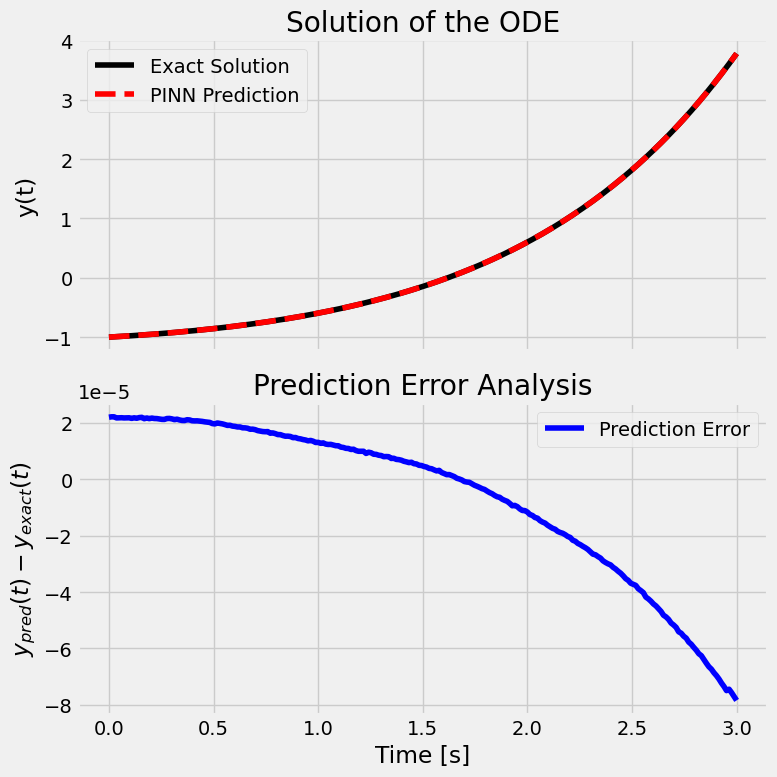

In [20]:
# Plotting the results
sol = smp.lambdify(t, sol.rhs, 'numpy')

t = np.linspace(0, 0.3, 250)
y_exact = sol(t)

# Plotting results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8), sharex = True)

ax1.plot(x, y_exact, "k-", label = "Exact Solution")
ax1.plot(x, y_pred, "r--", label = "PINN Prediction")
ax1.set_ylabel("y(t)")
ax1.set_title("Solution of the ODE")
ax1.legend()
ax1.grid(True)

error = y_pred.reshape(-1) - y_exact
ax2.plot(x, error, "b-", label = "Prediction Error")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("$y_{pred}(t) - y_{exact}(t)$")
ax2.set_title("Prediction Error Analysis")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Calculating stats
error = np.mean(np.abs(y_pred - y_exact))
std = np.std(np.abs(y_pred - y_exact))
print(f"Error: {error:.0f} +- {std:.0f}")

Error: 1 +- 1
